# Dependencies


In [1]:
# Install Packages
!pip install kagglehub nltk -q
!pip install seaborn -q

# Download packages for stopwords, lemmatization and tokenization
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Download Glove Embedding
# !wget http://nlp.stanford.edu/data/glove.6B.zip (Already Downloaded and uploaded via google drive)
# !unzip glove.6B.zip

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE
import random
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive


# Part 1

Part 1 [25 points]

In this assignment you will implement two deep learning algorithms to predict the genres of a movie from a short description given in text. This will be a multi-class classification problem since a movie can belong to multiple genres at the same time.
Models: 1. Implement a RNN model to predict the genre classes of a movie given the short textual description. There are 20 classes of genres in the dataset and each sample may have multiple genres to predict. You can use a sigmoid activation function to compute the probability of each classes and find multiple genres given a text description.
2. Implement a LSTM model to do the same and find accuracy, precision and recall and compare the numbers in your report.
3. The dataset contains the titles of the movies as well. Use the titles along with your descriptions and feed it to your one of your models and see if you can get any boost in your performance.
Dataset: IMDB data from 2006 to 2016( https://www.kaggle.com/datasets/PromptCloudHQ/imdb-data) has 1000 samples with information Title, Genre, Description, Director, Actors, Year, Runtime, Rating, Votes, Revenue, Metascrore. For this assignment you will use only the Title, Genre and Description columns.To load the data you can refer to the following code snippet:

Preprocessing:

Since the text description of the movies contain some noise and stopwords you need to preprocess and clean the data such as remove the stopwords, remove numbers, lemmatization etc. You can refer to the following code to do some preprocessing on your data or you can write your own.

Since you cannot feed your text data directly into a neural network, you need to tokenize each word and then use some sort of vector embedding to represent your words. In this assignment, you will use the glove embedding vectors to represent each of your words. Also, the neural network will only take a fixed size of input to it’s model, so you need to pad your text sequences to give it a fixed size. You can use the pad_sequences function from Tensorflow. Here is how you can download the Golve embedding and load the embedding vectors for all your words. This might take a while to download.

Multi-Label labelling:

Since your dataset has multiple labels for each sample, you need to preprocess the labels as well. There are 20 classes of genres and you need to create a vector of size 20 for each sample such as only the corresponding indices of genres are 1 and all other values are 0. You can follow the following code to preprocess your labels:

Once you have done all the preprocessing for your data you can load the data using a custom dataloader from keras. Use first 700 samples for training, 100 samples for validation and the last 200 to test your model. Train your networks for 20 epochs. Plot the graphs for training and validation loss, accuracy etc.
Deliverables: One .ipynb file with codes with data preprocessing and implementation of two models (feed forward and LSTM). Plot the graphs for loss and accuracy for training and validation. Report the numbers for test set for both models. Add titles to your text descriptions. Report the numbers for one of the models and compare with the previous model. Comment on how it helps or does not help.

## Only Description: Codes and Plots

In [3]:
# Import Dataset
path = kagglehub.dataset_download("PromptCloudHQ/imdb-data") # Download dataset from KaggleHub and get the full path to the CSV file
csv_file_path = os.path.join(path, 'IMDB-Movie-Data.csv')
data = pd.read_csv(csv_file_path)[['Title', 'Genre', 'Description']].dropna() # Read the CSV and select relevant columns. Drop any rows with missing values

# Preprocessing the data for Description only
stop_words = set(stopwords.words('english')) # Load English stopwords and initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()
def clean_text(text): # Define a function to clean and preprocess text
    tokens = nltk.word_tokenize(text.lower())  # Convert to lowercase and tokenize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalnum() and t not in stop_words]  # Remove stopwords and punctuation, then lemmatize
    return ' '.join(tokens)  # Join tokens back to a cleaned sentence
data['clean_text'] = data['Description'].apply(clean_text) # Apply the cleaning function to all movie descriptions

# Multi-Label Genre Encoding
genres = data['Genre'].apply(lambda x: [g.strip() for g in x.split(',')]) # Convert Genre strings to lists (e.g., "Action, Thriller" → ["Action", "Thriller"])
mlb = MultiLabelBinarizer() # Use MultiLabelBinarizer to one-hot encode multiple genres per movie
y = mlb.fit_transform(genres)  # y becomes a binary matrix of shape (num_samples, num_classes)

# Tokenization & Padding of Cleaned Text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") # Create and fit a tokenizer (limited to top 10,000 most frequent words)
tokenizer.fit_on_texts(data['clean_text'])
sequences = tokenizer.texts_to_sequences(data['clean_text']) # Convert each cleaned sentence to a list of word indices
padded = pad_sequences(sequences, maxlen=200, padding='post', truncating='post') # Pad each sequence to a fixed length of 200 (truncates or pads with zeros as needed)

# Load GloVe Embeddings
glove_file_path = '/content/drive/MyDrive/Colab_Drive/glove.6B.100d.txt' # Path to the GloVe file uploaded in google drive
embedding_index = {} # Load pre-trained word vectors into a dictionary
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
print('Found %s word vectors.' % len(embedding_index)) # Expected value is 400000

# Create Embedding Matrix
embedding_dim = 100  # We're using 100-dimensional GloVe vectors
word_index = tokenizer.word_index  # The word-to-index mapping learned from our data
num_words = min(10000, len(word_index) + 1)  # Limit to the vocab size used in tokenizer
embedding_matrix = np.zeros((num_words, embedding_dim)) # Initialize embedding matrix with zeros
for word, i in word_index.items(): # Fill embedding matrix with GloVe vectors for each word in our tokenizer
    if i < num_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Assign pre-trained vector


Found 400000 word vectors.


In [4]:
# Train-Validation-Test Split
X_train = padded[:700] # Training (700)
y_train = y[:700]
X_val = padded[700:800] # Validation (100)
y_val = y[700:800]
X_test = padded[800:] # Test (200) sets
y_test = y[800:]

In [5]:
# RNN Model
rnn_model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False), SimpleRNN(64), Dense(20, activation='sigmoid')])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = rnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, verbose=0) # Train with less verbose output
print("✅ RNN training completed.")

✅ RNN training completed.


In [6]:
# LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False), LSTM(64), Dense(20, activation='sigmoid')])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, verbose=0) # Train the model silently and print confirmation when done
print("✅ LSTM training completed.")

✅ LSTM training completed.


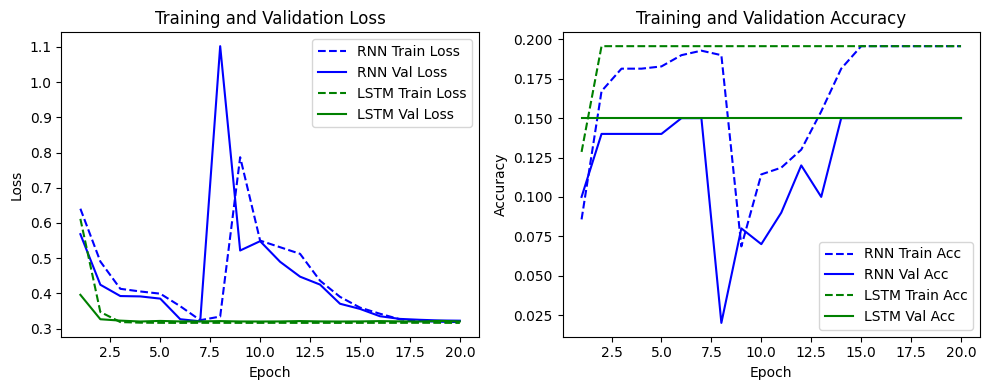

In [7]:
# Plot training and validation loss
def plot_combined_history(history_rnn, history_lstm):
    epochs = range(1, len(history_rnn.history['loss']) + 1)

    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_rnn.history['loss'], 'b--', label='RNN Train Loss')
    plt.plot(epochs, history_rnn.history['val_loss'], 'b-', label='RNN Val Loss')
    plt.plot(epochs, history_lstm.history['loss'], 'g--', label='LSTM Train Loss')
    plt.plot(epochs, history_lstm.history['val_loss'], 'g-', label='LSTM Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_rnn.history['accuracy'], 'b--', label='RNN Train Acc')
    plt.plot(epochs, history_rnn.history['val_accuracy'], 'b-', label='RNN Val Acc')
    plt.plot(epochs, history_lstm.history['accuracy'], 'g--', label='LSTM Train Acc')
    plt.plot(epochs, history_lstm.history['val_accuracy'], 'g-', label='LSTM Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_combined_history(history_rnn, history_lstm)


In [8]:
# Print classification report
def evaluate_and_print_report(model, X_test, y_test, model_name):
    # Predict probabilities
    y_pred = model.predict(X_test)

    # Convert probabilities to binary predictions
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Print classification report
    print(f"\n📋 Classification Report for {model_name}:")
    report = classification_report(y_test, y_pred_bin, target_names=mlb.classes_)
    print(report)

# Evaluate both models
evaluate_and_print_report(rnn_model, X_test, y_test, "RNN")
evaluate_and_print_report(lstm_model, X_test, y_test, "LSTM")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

📋 Classification Report for RNN:
              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        41
   Adventure       0.00      0.00      0.00        40
   Animation       0.00      0.00      0.00         8
   Biography       0.00      0.00      0.00        18
      Comedy       0.00      0.00      0.00        57
       Crime       0.00      0.00      0.00        25
       Drama       0.53      1.00      0.69       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.00      0.00      0.00        22
     History       0.00      0.00      0.00         4
      Horror       0.00      0.00      0.00        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00        21
     Romance       0.00      0.00      0.00        33
      Sci-Fi       0.00      0.00      0.00        12
       Sp

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

📋 Classification Report for LSTM:
              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        41
   Adventure       0.00      0.00      0.00        40
   Animation       0.00      0.00      0.00         8
   Biography       0.00      0.00      0.00        18
      Comedy       0.00      0.00      0.00        57
       Crime       0.00      0.00      0.00        25
       Drama       0.53      1.00      0.69       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.00      0.00      0.00        22
     History       0.00      0.00      0.00         4
      Horror       0.00      0.00      0.00        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00        21
     Romance       0.00      0.00      0.00        33
      Sci-Fi       0.00      0.00      0.00        12
       S

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


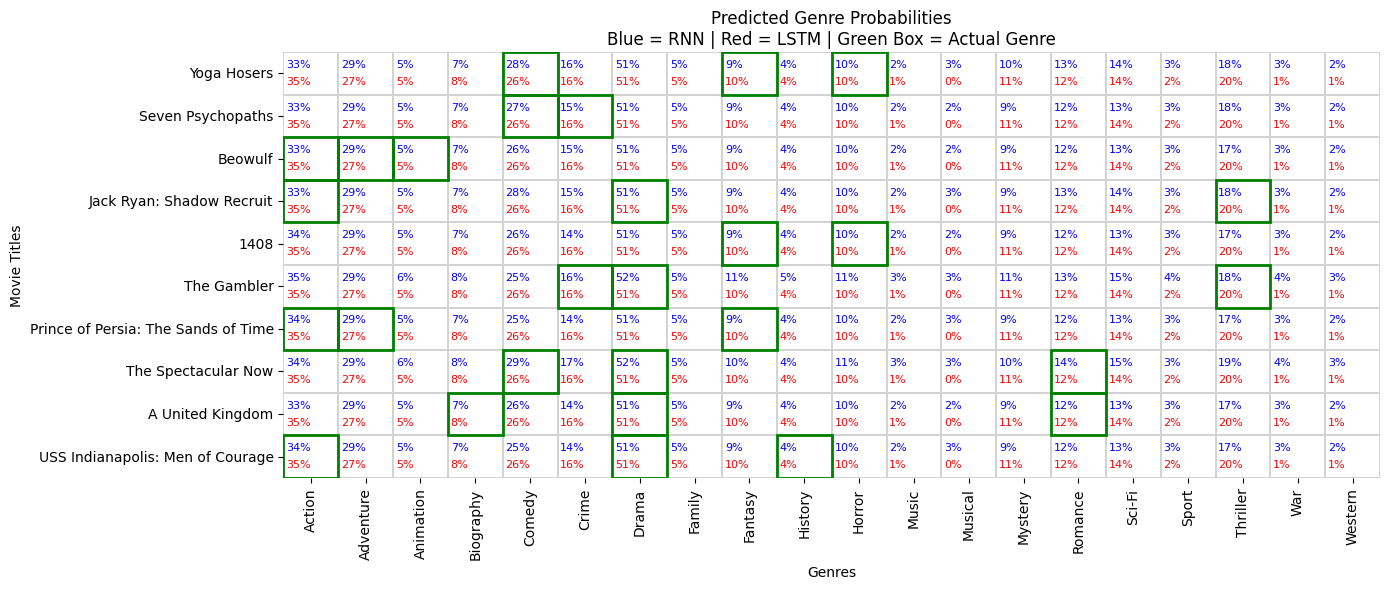

In [9]:
# Plot heatmap of RNN and LSTM to show the predicted probabilities of all genres with actual genre
def plot_dual_model_heatmap(rnn_model, lstm_model, X_test, y_test, movie_titles, mlb_classes, n_samples=10):
    """
    Displays predicted probabilities from both RNN and LSTM models as plain text.
    Actual genres are highlighted with green boxes (no heatmap shading).
    Parameters:
        rnn_model    : Trained RNN Keras model
        lstm_model   : Trained LSTM Keras model
        X_test       : Padded test sequences
        y_test       : Binary matrix of true genres
        movie_titles : List of movie titles corresponding to test samples
        mlb_classes  : List of genre labels
        n_samples    : Number of test samples to visualize (default 10)
    """
    # Get predictions
    rnn_probs = rnn_model.predict(X_test[:n_samples])
    lstm_probs = lstm_model.predict(X_test[:n_samples])
    actual_labels = y_test[:n_samples]

    # Prepare percentage strings
    rnn_percent = np.round(rnn_probs * 100).astype(int)
    lstm_percent = np.round(lstm_probs * 100).astype(int)
    fig, ax = plt.subplots(figsize=(14, 6))

    # Hide the background grid by plotting an empty white grid
    sns.heatmap(
        np.zeros_like(rnn_percent),  # Dummy grid
        annot=False,
        fmt='',
        cmap='Greys',
        cbar=False,
        xticklabels=mlb_classes,
        yticklabels=movie_titles[:n_samples],
        linewidths=0.3,
        linecolor='lightgrey',
        ax=ax
    )

    # Add percentage texts manually
    for i in range(n_samples):
        for j in range(len(mlb_classes)):
            rnn_txt = f"{rnn_percent[i, j]}%"
            lstm_txt = f"{lstm_percent[i, j]}%"
            ax.text(j + 0.05, i + 0.35, rnn_txt, color='blue', fontsize=8)
            ax.text(j + 0.05, i + 0.75, lstm_txt, color='red', fontsize=8)

            # Highlight actual genre with a green box
            if actual_labels[i, j] == 1:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='green', lw=2))

    plt.title("Predicted Genre Probabilities\nBlue = RNN | Red = LSTM | Green Box = Actual Genre")
    plt.xlabel("Genres")
    plt.ylabel("Movie Titles")
    plt.tight_layout()
    plt.show()

plot_dual_model_heatmap(rnn_model, lstm_model, X_test, y_test, data['Title'][800:].tolist(), mlb.classes_, n_samples=10)

## Description + Title: Codes and Plots

In [10]:
# Preprocessing the data for Description + Title
data['combined_text'] = data['Title'].apply(clean_text) + " " + data['clean_text']
sequences = tokenizer.texts_to_sequences(data['combined_text'])
padded_combined = pad_sequences(sequences, maxlen=200)

# Updated Input for combined Training, Validation and Training
X_train_c = padded_combined[:700]
X_val_c = padded_combined[700:800]
X_test_c = padded_combined[800:]

In [11]:
# RNN model trained on combined (title + description)
rnn_model_c = Sequential([Embedding(input_dim=num_words, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False), SimpleRNN(64), Dense(20, activation='sigmoid')  # 20 genres, multi-label
])
rnn_model_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn_c = rnn_model_c.fit(X_train_c, y_train, epochs=20, batch_size=32, validation_data=(X_val_c, y_val), verbose=0)
print("✅ RNN training completed (Description + Title).")


✅ RNN training completed (Description + Title).


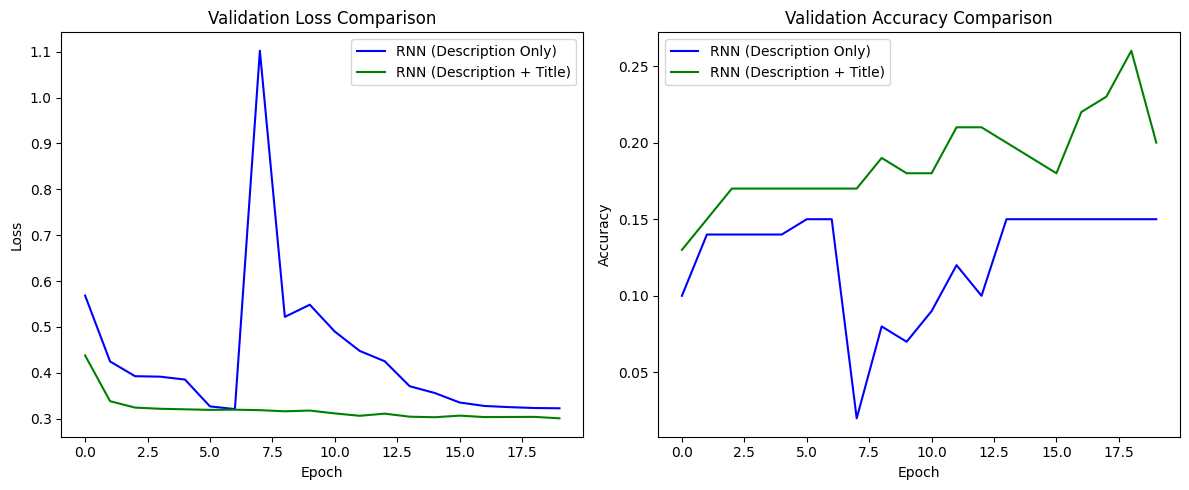

In [12]:
def plot_rnn_comparison(history_rnn, history_rnn_c):
    plt.figure(figsize=(12, 5))

    # Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_rnn.history['val_loss'], label='RNN (Description Only)', color='blue')
    plt.plot(history_rnn_c.history['val_loss'], label='RNN (Description + Title)', color='green')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_rnn.history['val_accuracy'], label='RNN (Description Only)', color='blue')
    plt.plot(history_rnn_c.history['val_accuracy'], label='RNN (Description + Title)', color='green')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_rnn_comparison(history_rnn, history_rnn_c)

In [13]:
from sklearn.metrics import classification_report

def compare_models(model1, model2, X_test1, X_test2, y_test, model1_name="Model 1", model2_name="Model 2"):
    """
    Compare classification reports of two models.

    Parameters:
        model1, model2: Trained Keras models
        X_test1, X_test2: Corresponding test sets
        y_test: Ground truth binary labels
        model1_name, model2_name: Custom names for the models
    """
    for model, X_test, name in zip([model1, model2], [X_test1, X_test2], [model1_name, model2_name]):
        y_pred = model.predict(X_test)
        y_pred_bin = (y_pred > 0.5).astype(int)
        print(f"\n📋 Classification Report for {name}:")
        print(classification_report(y_test, y_pred_bin, target_names=mlb.classes_))

# Run comparison
compare_models(rnn_model, rnn_model_c, X_test, X_test_c, y_test, "RNN (Description Only)", "RNN (Title + Description)")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

📋 Classification Report for RNN (Description Only):
              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        41
   Adventure       0.00      0.00      0.00        40
   Animation       0.00      0.00      0.00         8
   Biography       0.00      0.00      0.00        18
      Comedy       0.00      0.00      0.00        57
       Crime       0.00      0.00      0.00        25
       Drama       0.53      1.00      0.69       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.00      0.00      0.00        22
     History       0.00      0.00      0.00         4
      Horror       0.00      0.00      0.00        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00        21
     Romance       0.00      0.00      0.00        33
      Sci-Fi       0.00      0.00      0.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

📋 Classification Report for RNN (Title + Description):
              precision    recall  f1-score   support

      Action       0.68      0.66      0.67        41
   Adventure       0.42      0.33      0.37        40
   Animation       0.00      0.00      0.00         8
   Biography       0.00      0.00      0.00        18
      Comedy       0.60      0.16      0.25        57
       Crime       0.62      0.20      0.30        25
       Drama       0.58      0.72      0.64       106
      Family       0.00      0.00      0.00        13
     Fantasy       0.00      0.00      0.00        22
     History       0.00      0.00      0.00         4
      Horror       0.00      0.00      0.00        32
       Music       0.00      0.00      0.00         5
     Musical       0.00      0.00      0.00         2
     Mystery       0.00      0.00      0.00        21
     Romance       0.00      0.00      0.00        33
      Sci-Fi       0.50      0.08      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


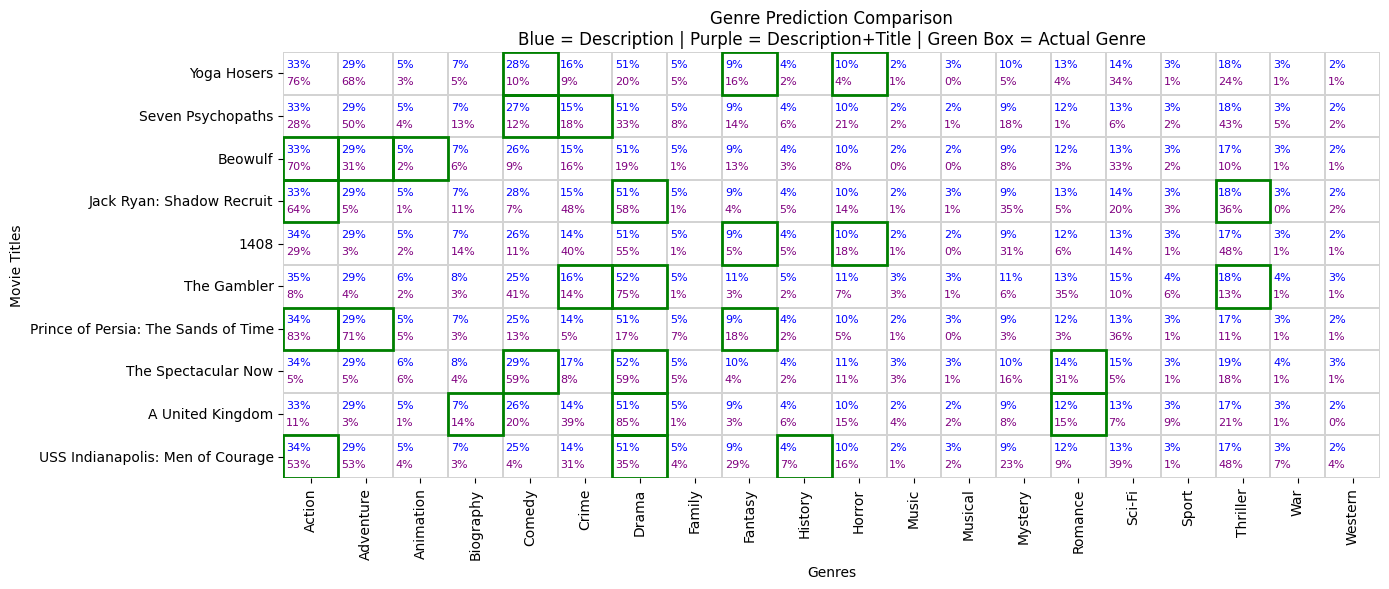

In [14]:
def plot_rnn_vs_rnn_c_heatmap(rnn_model, rnn_model_c,
                              X_test_rnn, X_test_rnn_c,
                              y_test, movie_titles, mlb_classes, n_samples=10):
    """
    Compare RNN (description only) and RNN_C (title + description) model predictions.
    Green box = Actual genre
    Blue = RNN predicted probability
    Purple = RNN_C predicted probability
    """
    # Get predictions
    rnn_probs = rnn_model.predict(X_test_rnn[:n_samples])
    rnn_c_probs = rnn_model_c.predict(X_test_rnn_c[:n_samples])
    actual_labels = y_test[:n_samples]

    # Convert to percentages
    rnn_percent = np.round(rnn_probs * 100).astype(int)
    rnn_c_percent = np.round(rnn_c_probs * 100).astype(int)

    # Create dummy background
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(
        np.zeros_like(rnn_percent),
        annot=False,
        fmt='',
        cmap='Greys',
        cbar=False,
        xticklabels=mlb_classes,
        yticklabels=movie_titles[:n_samples],
        linewidths=0.3,
        linecolor='lightgrey',
        ax=ax
    )

    # Add percentage annotations
    for i in range(n_samples):
        for j in range(len(mlb_classes)):
            txt_rnn = f"{rnn_percent[i, j]}%"
            txt_rnn_c = f"{rnn_c_percent[i, j]}%"
            ax.text(j + 0.05, i + 0.35, txt_rnn, color='blue', fontsize=8)
            ax.text(j + 0.05, i + 0.75, txt_rnn_c, color='purple', fontsize=8)

            # Green box = actual genre
            if actual_labels[i, j] == 1:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='green', lw=2))

    plt.title("Genre Prediction Comparison\nBlue = Description | Purple = Description+Title | Green Box = Actual Genre")
    plt.xlabel("Genres")
    plt.ylabel("Movie Titles")
    plt.tight_layout()
    plt.show()

plot_rnn_vs_rnn_c_heatmap(rnn_model, rnn_model_c, X_test, X_test_c, y_test, data['Title'][800:].tolist(),  mlb.classes_, n_samples=10)


## Report

**Model Comparison Summary: Multi-Label Genre Classification**


Models Evaluated
*   RNN (Description only)
*   LSTM (Description only)
*   RNN (Description + Title)
---


**Performance with Description Only**



Both RNN and LSTM models showed poor genre prediction except for the genre Drama due to class imbalance. Only Drama was consistently predicted well with Precision: 0.53 (both models), Recall: 1.00 and F1-score: 0.31. All other genres had precision, recall, and F1-score near zero.
Validation Accuracy was fairly similar with RNN: ~0.14 and  LSTM: ~0.15

The models overfit on predicting Drama due to its high support (Class imbalance) in the dataset and failed to generalize.

---



**Performance with Description + Title (RNN Only)**



Significant improvement across many genres. Action: Precision ↑ from 0.00 to 0.68, Recall 0.61. Adventure: Precision ↑ to 0.41, Recall 0.30. Drama: Still strong — Precision 0.54, Recall 0.72, F1 0.62. Other genres like Comedy, Crime, Thriller also saw small gains. Validation Accuracy: Improved to ~0.24. F1-score (samples avg): Improved from 0.31 → 0.34. Micro-average F1-score: 0.36 vs 0.31 before.

The RNN model performed better with Description + Title compared to Description only.

---

**Conclusion**



*   RNN and LSTM models struggle with genre diversity when trained only on descriptions. Most genres are underrepresented, causing poor recall and zero precision.
*   Adding the Title alongside Description dramatically improves the RNN’s ability to distinguish between genres.
*   RNN (Description + Title) is the best-performing model, achieving higher recall and precision across multiple genres and overall better validation accuracy.










# Part 2

Part 2 [25 points]

In this part you will implement a convolutional neural network to classify natural images into 6 classes. This dataset is called Intel Image Classification dataset which has 6 classes. The dataset has 14,000 training images; 3,000 validation and 7000 pred_seg images. You need to train your model using the 14000 training images and test it on 3000 validation images. You do not need to do anything on the 7000 pred_seg images. The images of the dataset belong to classes such as streets, buildings, woods, mountains, seas, and glaciers. The data is organized into subfolders with class names for both training and validation (test) sets. When you load the images to a dotaloader, you need to label the images according to your folder names. You can load the images using opencv library.
This is how you can download the data:

You can also download the images from the following link, unzip it and then upload to your google drive:

https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download

Models:
1.
Implement one CNN model with 3 Conv layer and three and 3 max_pooling layers. Add a dropout layer and a dense layer before the output layer

2.
Implement a model with 6 Conv layers and 3 pooling layers. Add a dropout layer and a dense layer before the output layer

3.
Play around with different learning rates, batch sizes and optimizers.

Deliverables:

Include your code and report. Document your findings in a table and write a summary. Report your numbers in terms of total accuracy and per-class accuracy on the test set (3000 images). Visualize your prediction from test set with the label for 2 samples.

## Grayscale

In [15]:
# Set paths
zip_path = '/content/drive/MyDrive/Colab_Drive/Intel_Image_classification_dataset.zip'
extract_path = '/content/intel_data'

# Unzip the dataset
import zipfile
import os

if not os.path.exists(extract_path):  # Avoid re-extracting if already done
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted.")
else:
    print("ℹ️ Dataset already extracted.")

✅ Dataset extracted.


In [16]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Define dataset paths
train_dir = os.path.join(extract_path, 'seg_train', 'seg_train')
test_dir = os.path.join(extract_path, 'seg_test', 'seg_test')

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [17]:
class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        return self.model(x)

In [18]:
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
def train_and_evaluate(model, optimizer, criterion, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"\n✅ Test Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_preds, target_names=classes))
    return model

In [20]:
# Model 1
model1 = CNNModel1()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Model 1 (3 Conv Layers)")
model1 = train_and_evaluate(model1, optimizer1, criterion, epochs=10)

# Model 2
model2 = CNNModel2()
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

print("\nTraining Model 2 (6 Conv Layers)")
model2 = train_and_evaluate(model2, optimizer2, criterion, epochs=10)

Training Model 1 (3 Conv Layers)
Epoch 1/10, Loss: 198.8115
Epoch 2/10, Loss: 124.6279
Epoch 3/10, Loss: 101.1592
Epoch 4/10, Loss: 78.4620
Epoch 5/10, Loss: 59.6772
Epoch 6/10, Loss: 45.0024
Epoch 7/10, Loss: 33.0661
Epoch 8/10, Loss: 27.1370
Epoch 9/10, Loss: 20.5397
Epoch 10/10, Loss: 17.7101

✅ Test Accuracy: 0.8400
              precision    recall  f1-score   support

   buildings       0.81      0.82      0.81       437
      forest       0.95      0.94      0.94       474
     glacier       0.88      0.71      0.78       553
    mountain       0.75      0.87      0.80       525
         sea       0.86      0.85      0.85       510
      street       0.83      0.87      0.85       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000


Training Model 2 (6 Conv Layers)
Epoch 1/10, Loss: 314.4100
Epoch 2/10, Loss: 205.0008
Epoch 3/10, Loss: 176.4681
Epoch 4/10, Loss: 15

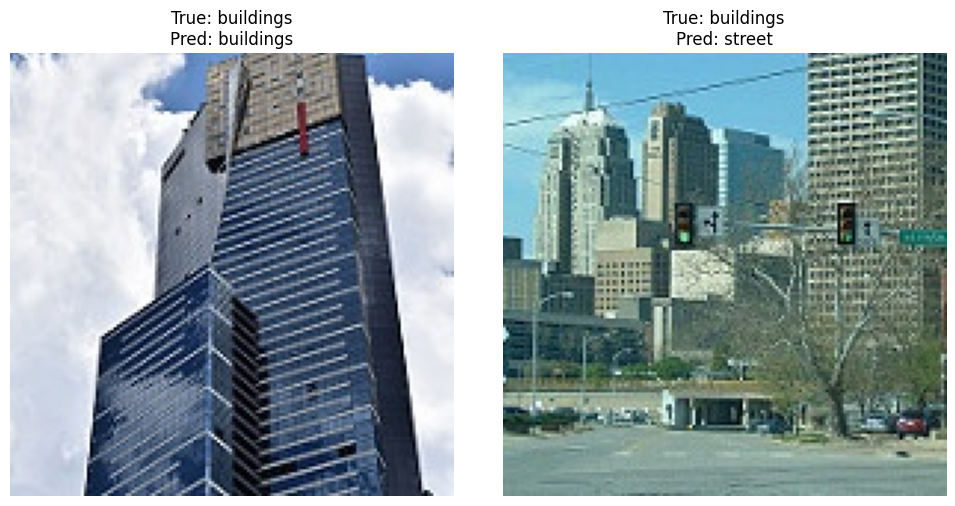

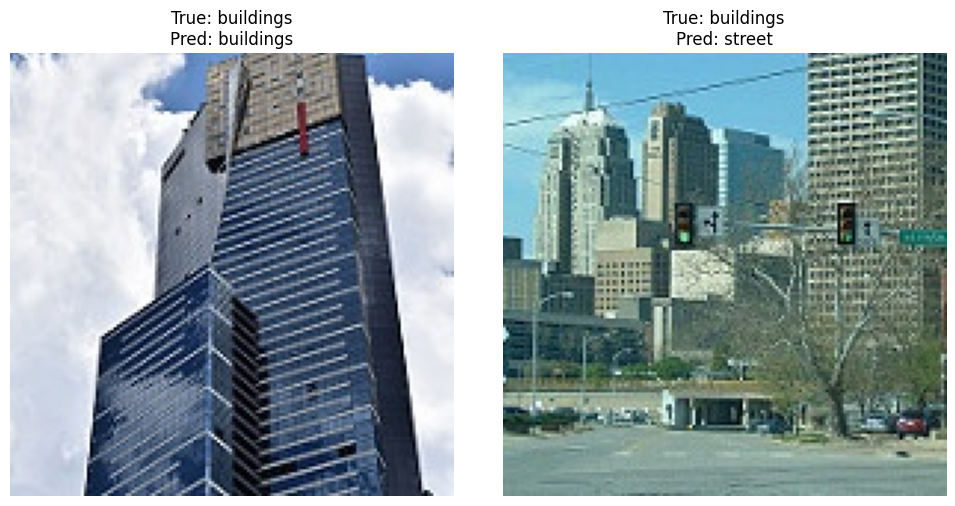

In [21]:
def visualize_predictions(model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(2):
        img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
        axs[i].imshow(img)
        axs[i].set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model1)
visualize_predictions(model2)

## RGB

ℹ️ Dataset already extracted.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training Model 1 (3 Conv Layers)
Epoch 1/10, Loss: 205.1147
Epoch 2/10, Loss: 125.6886
Epoch 3/10, Loss: 101.5228
Epoch 4/10, Loss: 82.2969
Epoch 5/10, Loss: 64.4013
Epoch 6/10, Loss: 46.7946
Epoch 7/10, Loss: 37.2368
Epoch 8/10, Loss: 26.5214
Epoch 9/10, Loss: 21.3362
Epoch 10/10, Loss: 18.2181

✅ Test Accuracy: 0.8413
              precision    recall  f1-score   support

   buildings       0.87      0.70      0.78       437
      forest       0.96      0.95      0.95       474
     glacier       0.86      0.76      0.81       553
    mountain       0.76      0.86      0.81       525
         sea       0.87      0.85      0.86       510
      street       0.77      0.92      0.84       501

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000


Training Model 2 (6 Conv Layers

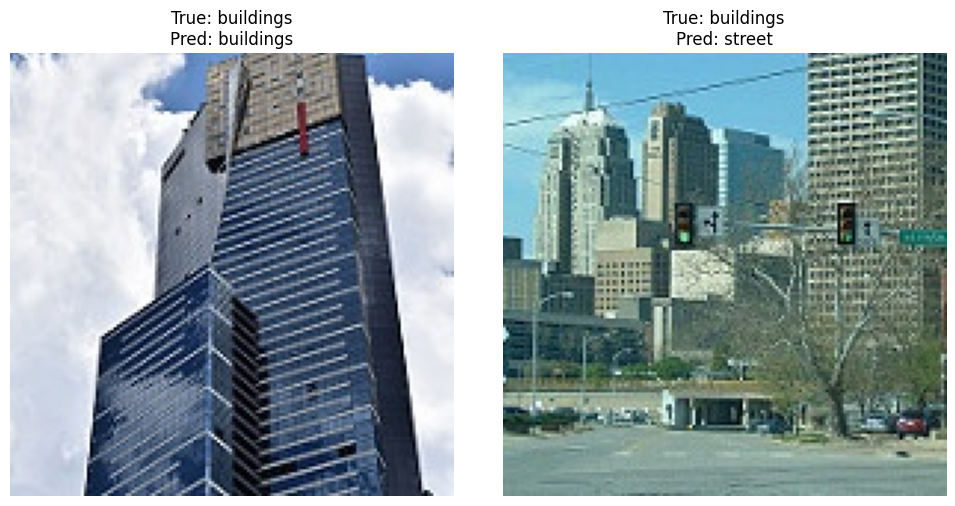

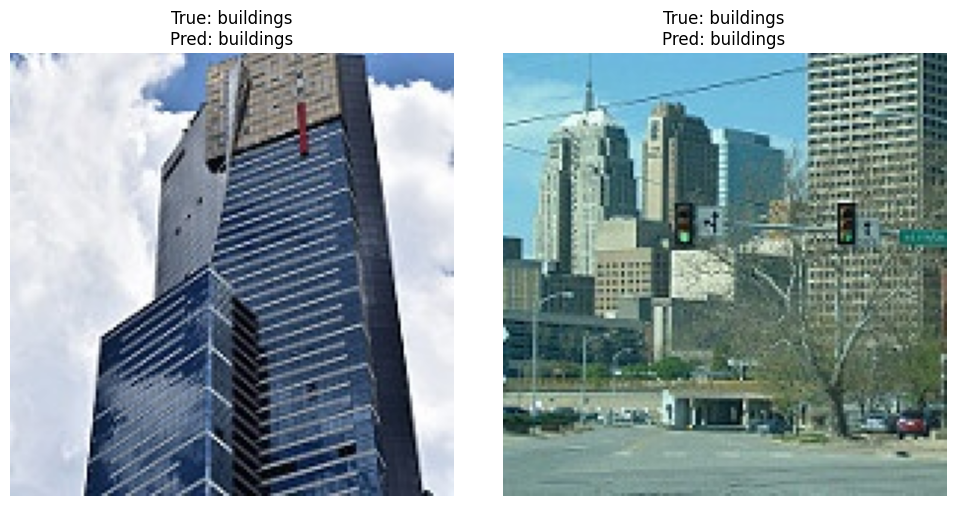

In [22]:
# 📦 Imports
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 📁 Set paths
zip_path = '/content/drive/MyDrive/Colab_Drive/Intel_Image_classification_dataset.zip'
extract_path = '/content/intel_data'

# 🗂️ Unzip the dataset
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted.")
else:
    print("ℹ️ Dataset already extracted.")

# 🔄 Define transforms (for RGB)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # RGB-aware
])

# 📂 Define dataset paths
train_dir = os.path.join(extract_path, 'seg_train', 'seg_train')
test_dir = os.path.join(extract_path, 'seg_test', 'seg_test')

# 📸 Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# 🚚 Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 🏷️ Class names
classes = train_dataset.classes
print("Classes:", classes)

# 🧠 Model 1: 3 Conv Layers
class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        return self.model(x)

# 🧠 Model 2: 6 Conv Layers
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        return self.model(x)

# ⚙️ Train and evaluate function
def train_and_evaluate(model, optimizer, criterion, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    # ✅ Evaluation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"\n✅ Test Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_preds, target_names=classes))
    return model

# 🚀 Train Model 1
model1 = CNNModel1()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Model 1 (3 Conv Layers)")
model1 = train_and_evaluate(model1, optimizer1, criterion, epochs=10)

# 🚀 Train Model 2
model2 = CNNModel2()
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

print("\nTraining Model 2 (6 Conv Layers)")
model2 = train_and_evaluate(model2, optimizer2, criterion, epochs=10)

# 🎨 Visualize predictions
def visualize_predictions(model):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    images, labels = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(2):
        img = images[i].cpu()
        img = img * 0.5 + 0.5  # Unnormalize
        img = img.permute(1, 2, 0).numpy()  # CHW → HWC
        axs[i].imshow(img)
        axs[i].set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# 🖼️ Show prediction results
visualize_predictions(model1)
visualize_predictions(model2)


## Report

**Model Performance Report: Intel Image Classification**


I compared the performance of two convolutional neural network (CNN) models: a 3-layer CNN and a deeper 6-layer CNN. I also trained both models on grayscale and RGB versions of the Intel Image Classification dataset. The goal was to evaluate how input color information (grayscale vs. RGB) and network depth affected classification accuracy and class-wise performance.

---

**GrayScale**


For grayscale images, the 3-layer model achieved a test accuracy of **84.00%**, while the 6-layer model reached **81.13%**. This suggests that the simpler architecture generalized better to the grayscale dataset. The class-wise results show that the 3-layer model had more consistent performance across most classes. In contrast, the deeper model showed slight improvements in some categories like glacier and forest but underperformed in others such as mountain and buildings, indicating potential overfitting or increased complexity not translating into better generalization for grayscale inputs.

---

**RGB**

When the same models were trained on RGB images, the 3-layer model again performed slightly better with a test accuracy of **84.13%**, while the 6-layer model dropped to **79.17%**. Interestingly, while RGB input introduced more visual features and color cues, it did not significantly boost the 3-layer model’s accuracy compared to its grayscale counterpart. The deeper model, however, performed worse on RGB data than on grayscale, suggesting that the additional complexity combined with RGB input may have led to overfitting or difficulty in training efficiently with the available data.

---

**Prediction Comparison**

Visual analysis of predictions on two test samples revealed another layer of insight. For the **grayscale-trained models**, both the 3-layer and 6-layer CNNs correctly predicted the first image as a **building**, but both failed on the second image, misclassifying it as **street** instead of **building**.

However, under **RGB training**, the 6-layer CNN correctly classified the second image as **building**, while the 3-layer CNN misclassified it. This suggests that although overall performance of the RGB 6-layer model was lower, it potentially benefited from the richer feature representation of RGB in more challenging or ambiguous samples.

---

**Conclusion**


*   The 3-layer CNN remained more stable and accurate across both grayscale and RGB datasets, while the 6-layer model exhibited inconsistencies likely due to overfitting.
*   The RGB 6-layer model showed specific strengths in complex cases, hinting at the trade-off between model depth and input richness that can influence performance in nuanced ways.


